In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import Perceptron,PassiveAggressiveClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier #Multi-Layer-Perceptron
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from scikitplot.metrics import plot_roc_curve

from sklearn.preprocessing import StandardScaler,MinMaxScaler

import os
from functools import reduce

import seaborn as sns
%matplotlib inline


# Lectura de datos

In [3]:
ruta=os.getcwd()+'/datos' # Get current work directory
#ruta ='/home/osvaldosantos823/Cuadernos_ML/Kaggle/titanic/datos'
l_arch=[os.path.join(ruta,a) for a in os.listdir(ruta) if a.endswith('.csv') ]
l_arch

['/home/oszwaldo/Documentos/Projects/Cuadernos_ML/Kaggle/titanic/datos/test.csv',
 '/home/oszwaldo/Documentos/Projects/Cuadernos_ML/Kaggle/titanic/datos/train.csv']

In [4]:
df = pd.read_csv(l_arch[-1])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
vard=['Pclass','Sex','Embarked'] # Cabin tal vez
varori=['Age','SibSp','Parch','Fare'] # variables continuas originales
um='PassengerId'
tgt='Survived'
#df[varc].head()

In [6]:
df.loc[:,[um]+vard+[tgt]].head(2)

,PassengerId,Pclass,Sex,Embarked,Survived
0,1,3,male,S,0
1,2,1,female,C,1


# Ingeniería de datos

In [7]:
def trans(df,v,varori):
    aux=df.pivot_table(index=um,columns=v,values=varori,aggfunc=['min','max','mean','std','sum']).fillna(0)
    aux.columns=["v_"+v+"_"+"".join(str(x[2]))+"_"+"".join(x[1])+"_"+"".join(x[0]) for x in aux.columns]
    return aux

In [8]:
# Parte necesaria para los nuevos datos
X=reduce(lambda x,y:pd.merge(x,y,on=um,how='outer'), map(lambda v:trans(df,v,varori),vard) )
# Se definen nuevas variables continuas
varc=[a for a in X.columns if a[:2]=='v_']

In [9]:
X.head(2)

,v_Pclass_1_Age_min,v_Pclass_2_Age_min,v_Pclass_3_Age_min,v_Pclass_1_Fare_min,v_Pclass_2_Fare_min,v_Pclass_3_Fare_min,v_Pclass_1_Parch_min,v_Pclass_2_Parch_min,v_Pclass_3_Parch_min,v_Pclass_1_SibSp_min,...,v_Embarked_S_Age_sum,v_Embarked_C_Fare_sum,v_Embarked_Q_Fare_sum,v_Embarked_S_Fare_sum,v_Embarked_C_Parch_sum,v_Embarked_Q_Parch_sum,v_Embarked_S_Parch_sum,v_Embarked_C_SibSp_sum,v_Embarked_Q_SibSp_sum,v_Embarked_S_SibSp_sum
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,22.0,0.0000,0.0,7.25,0.0,0.0,0.0,0.0,...,22.0,0.0000,0.0,7.25,0.0,0.0,0.0,0.0,0.0,1.0
2,38.0,0.0,0.0,71.2833,0.0,0.00,0.0,0.0,0.0,1.0,...,0.0,71.2833,0.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0


In [10]:
tad=pd.merge(X,df[[um]+[tgt]],on=um,how="inner")
tad.shape

(891, 130)

# Análisis exploratorio

## Missings

In [11]:
miss=1-tad[varc].describe().T[['count']]/len(tad)
miss

,count
v_Pclass_1_Age_min,0.000000
v_Pclass_2_Age_min,0.000000
v_Pclass_3_Age_min,0.000000
v_Pclass_1_Fare_min,0.000000
v_Pclass_2_Fare_min,0.000000
...,...
v_Embarked_Q_Parch_sum,0.002245
v_Embarked_S_Parch_sum,0.002245
v_Embarked_C_SibSp_sum,0.002245
v_Embarked_Q_SibSp_sum,0.002245


In [12]:
tad.shape,tad.dropna().shape

((891, 130), (889, 130))

In [13]:
tad=tad.dropna().reset_index(drop=True)
tad.tail()

,PassengerId,v_Pclass_1_Age_min,v_Pclass_2_Age_min,v_Pclass_3_Age_min,v_Pclass_1_Fare_min,v_Pclass_2_Fare_min,v_Pclass_3_Fare_min,v_Pclass_1_Parch_min,v_Pclass_2_Parch_min,v_Pclass_3_Parch_min,...,v_Embarked_C_Fare_sum,v_Embarked_Q_Fare_sum,v_Embarked_S_Fare_sum,v_Embarked_C_Parch_sum,v_Embarked_Q_Parch_sum,v_Embarked_S_Parch_sum,v_Embarked_C_SibSp_sum,v_Embarked_Q_SibSp_sum,v_Embarked_S_SibSp_sum,Survived
884,887,0.0,27.0,0.0,0.0,13.0,0.00,0.0,0.0,0.0,...,0.0,0.00,13.00,0.0,0.0,0.0,0.0,0.0,0.0,0
885,888,19.0,0.0,0.0,30.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,30.00,0.0,0.0,0.0,0.0,0.0,0.0,1
886,889,0.0,0.0,0.0,0.0,0.0,23.45,0.0,0.0,2.0,...,0.0,0.00,23.45,0.0,0.0,2.0,0.0,0.0,1.0,0
887,890,26.0,0.0,0.0,30.0,0.0,0.00,0.0,0.0,0.0,...,30.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1
888,891,0.0,0.0,32.0,0.0,0.0,7.75,0.0,0.0,0.0,...,0.0,7.75,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0


## Extremos

In [14]:
ol = tad[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist()
for v,li,ls in ol:
    tad['ol_%s'%v] = ((tad[v]<li)|(tad[v]>ls)).astype(int)

In [15]:
varo = [v for v in tad.columns if v[:2]=='ol']
tad['ext'] = tad[varo].max(axis=1)

In [16]:
tad.drop(varo,axis=1,inplace=True)

In [17]:
tad.head(2)

,PassengerId,v_Pclass_1_Age_min,v_Pclass_2_Age_min,v_Pclass_3_Age_min,v_Pclass_1_Fare_min,v_Pclass_2_Fare_min,v_Pclass_3_Fare_min,v_Pclass_1_Parch_min,v_Pclass_2_Parch_min,v_Pclass_3_Parch_min,...,v_Embarked_Q_Fare_sum,v_Embarked_S_Fare_sum,v_Embarked_C_Parch_sum,v_Embarked_Q_Parch_sum,v_Embarked_S_Parch_sum,v_Embarked_C_SibSp_sum,v_Embarked_Q_SibSp_sum,v_Embarked_S_SibSp_sum,Survived,ext
0,1,0.0,0.0,22.0,0.0000,0.0,7.25,0.0,0.0,0.0,...,0.0,7.25,0.0,0.0,0.0,0.0,0.0,1.0,0,0
1,2,38.0,0.0,0.0,71.2833,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0,1,0


In [18]:
# Nos quedamos solo con las filas que no son extremas
tad_e=tad.loc[tad.ext==0].reset_index(drop=True).drop('ext',axis=1)

In [19]:
tad_e.shape,tad.shape

((782, 130), (889, 131))

In [20]:
from scipy.stats import ks_2samp
ks = pd.DataFrame(map(lambda v:(v,ks_2samp(tad_e[v],tad[v]).statistic),varc),columns=['var','ks'])
rotas = sorted(ks.loc[ks['ks']>0.1]['var'])
rotas # El resultado vacío nos indica que no hay diferencia estadística entre tad y tad_e

[]

In [21]:
tad=tad_e

## Unarias

In [22]:
# Eliminación de columnas innecesarias o unarias
mat=tad[varc].describe().T[['max']]
columnas=mat.loc[mat['max']<=1].T.columns.to_list()
tad=tad.drop(columnas,axis=1)
varc=[a for a in tad.columns if a[:2]=='v_']

## Multicolinealidad

In [23]:
from varclushi import VarClusHi

In [24]:
vc = VarClusHi(df=tad[varc],maxclus=10)

In [25]:
vc.varclus()
r2 = vc.rsquare

In [26]:
r2 = r2.sort_values(by=['Cluster','RS_Ratio'],ascending=[1,1]).reset_index(drop=True)

In [27]:
r2['importancia'] = r2.groupby('Cluster').cumcount()+1

In [28]:
best = r2.loc[r2.importancia==1]['Variable'].tolist()
best

['v_Pclass_3_SibSp_min',
 'v_Pclass_1_Fare_min',
 'v_Sex_female_Parch_min',
 'v_Embarked_C_Fare_min',
 'v_Embarked_S_Age_min',
 'v_Embarked_Q_Age_min',
 'v_Pclass_2_Age_min',
 'v_Embarked_C_Parch_min',
 'v_Sex_female_Age_min',
 'v_Pclass_2_Parch_min']

## Correlación

In [29]:
tad.shape

(782, 110)

In [30]:
mat=tad[varc].corr()
n=len(mat)
li=0.99
nom=[]
for i in range(1,n):
    if(mat.iloc[i].name in nom):
        continue
    for j in range(i+1,n):
        if(mat.iloc[i,j]>li or mat.iloc[i,j]<(-li)):
            nom.append(mat.iloc[:,j].name)
tad_c=tad.drop(nom,axis=1)
tad_c.shape

(782, 30)

In [53]:
corvar=[a for a in tad_c.columns if a[:2]=='v_']

In [54]:
corvar

['v_Pclass_1_Age_min',
 'v_Pclass_2_Age_min',
 'v_Pclass_3_Age_min',
 'v_Pclass_1_Fare_min',
 'v_Pclass_2_Fare_min',
 'v_Pclass_3_Fare_min',
 'v_Pclass_1_Parch_min',
 'v_Pclass_2_Parch_min',
 'v_Pclass_3_Parch_min',
 'v_Pclass_3_SibSp_min',
 'v_Pclass_1_Age_max',
 'v_Sex_female_Age_min',
 'v_Sex_male_Age_min',
 'v_Sex_female_Fare_min',
 'v_Sex_male_Fare_min',
 'v_Sex_female_Parch_min',
 'v_Sex_male_Parch_min',
 'v_Sex_female_SibSp_min',
 'v_Sex_male_SibSp_min',
 'v_Embarked_C_Age_min',
 'v_Embarked_Q_Age_min',
 'v_Embarked_S_Age_min',
 'v_Embarked_C_Fare_min',
 'v_Embarked_Q_Fare_min',
 'v_Embarked_S_Fare_min',
 'v_Embarked_C_Parch_min',
 'v_Embarked_S_Parch_min',
 'v_Embarked_S_SibSp_min']

array([[<AxesSubplot:title={'center':'v_Pclass_3_SibSp_min'}>,
        <AxesSubplot:title={'center':'v_Pclass_1_Fare_min'}>,
        <AxesSubplot:title={'center':'v_Sex_female_Parch_min'}>],
       [<AxesSubplot:title={'center':'v_Embarked_C_Fare_min'}>,
        <AxesSubplot:title={'center':'v_Embarked_S_Age_min'}>,
        <AxesSubplot:title={'center':'v_Embarked_Q_Age_min'}>],
       [<AxesSubplot:title={'center':'v_Pclass_2_Age_min'}>,
        <AxesSubplot:title={'center':'v_Embarked_C_Parch_min'}>,
        <AxesSubplot:title={'center':'v_Sex_female_Age_min'}>],
       [<AxesSubplot:title={'center':'v_Pclass_2_Parch_min'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

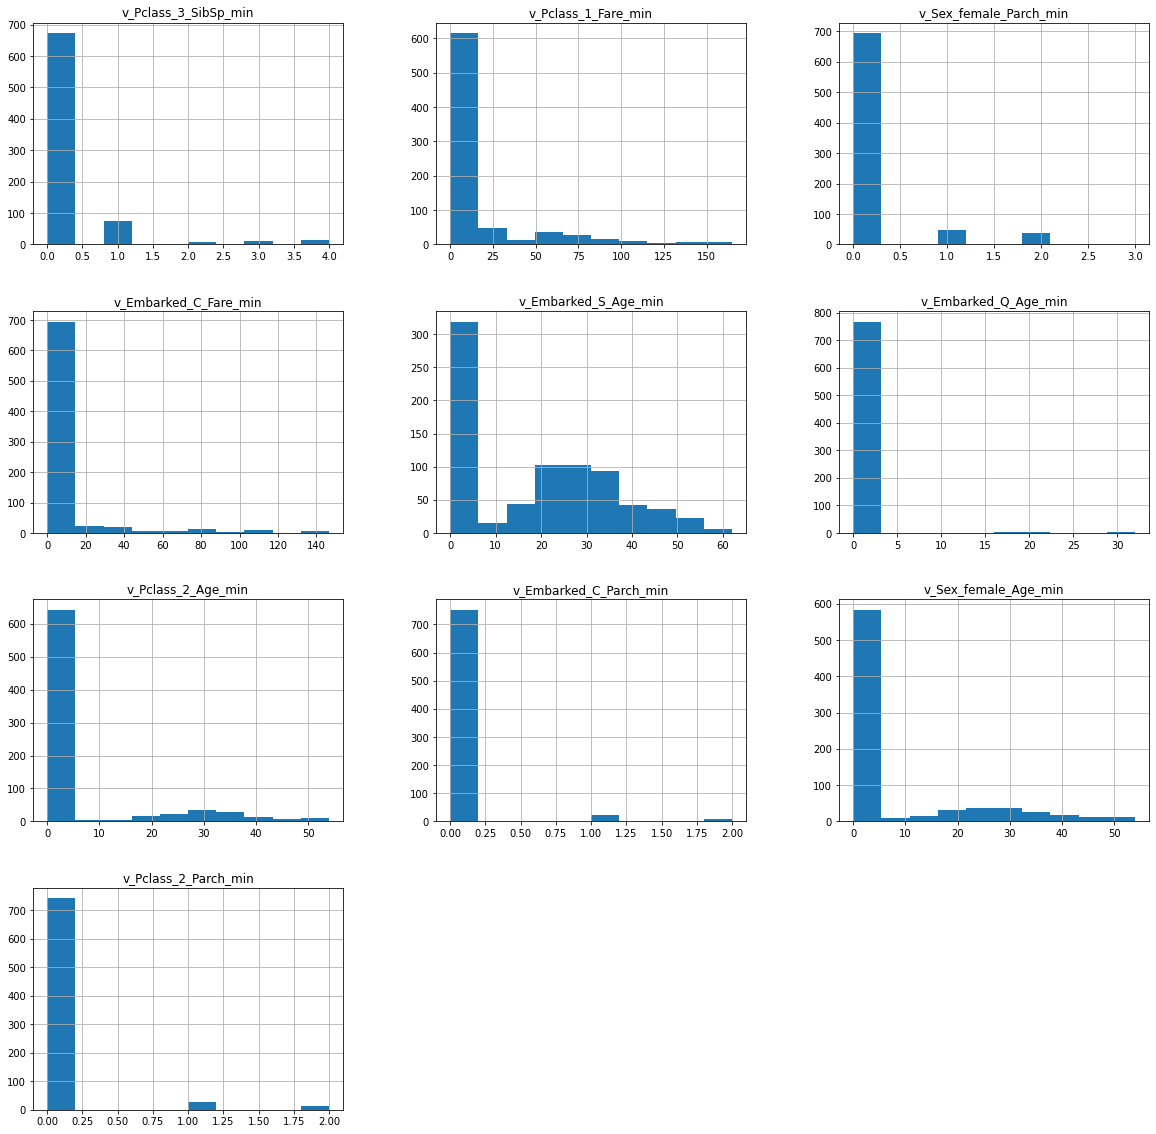

In [32]:
tad[best].hist(figsize=(20,20))

# Modelos

## Perceptron

In [55]:
X=tad[corvar].copy()
y=tad[tgt]
Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.7)

In [128]:
modelo = Perceptron()

In [129]:
#l2 es la norma cuadrada euclidiana y l1 es la norma absoluta, elasticnet es una combinación
#Se aplica el penalty a la función de perdida 0-1 del perceptron
hyper = dict(penalty = ['l2','l1','elasticnet'],
             fit_intercept=[True,False],
             max_iter=range(1000,21000,1000),
             eta0 = np.arange(0.1,1,0.1))

In [130]:
grid = GridSearchCV(estimator=modelo,
                    error_score='roc_auc',
                    param_grid=hyper,
                    cv=3,
                    n_jobs=-1,
                    verbose=True)

grid.fit(Xt,yt)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 1500 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2900 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  2.2min finished


GridSearchCV(cv=3, error_score='roc_auc', estimator=Perceptron(), n_jobs=-1,
             param_grid={'eta0': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'fit_intercept': [True, False],
                         'max_iter': range(1000, 21000, 1000),
                         'penalty': ['l2', 'l1', 'elasticnet']},
             verbose=True)

In [131]:
print(grid.best_score_)

print(grid.best_params_)

0.7567405272323305
{'eta0': 0.8, 'fit_intercept': False, 'max_iter': 1000, 'penalty': 'l2'}


In [144]:
modelo = grid.best_estimator_
modelo.fit(Xt,yt)

Perceptron(eta0=0.8, fit_intercept=False, penalty='l2')

In [145]:
print(accuracy_score(y_true=yt,y_pred=modelo.predict(Xt)))
print(accuracy_score(y_true=yv,y_pred=modelo.predict(Xv)))

print(confusion_matrix(y_true=yt,y_pred=modelo.predict(Xt)))
print(confusion_matrix(y_true=yv,y_pred=modelo.predict(Xv)))

0.7020109689213894
0.6340425531914894
[[278  80]
 [ 83 106]]
[[101  26]
 [ 60  48]]


## Pasivo-agresivo

In [78]:
modelo2 = PassiveAggressiveClassifier()

In [79]:
hyper = dict(C = np.arange(0.1,2,0.1),
             fit_intercept=[True,False],
             max_iter=range(1000,21000,1000))

In [80]:
grid = GridSearchCV(estimator=modelo2,
                    error_score='roc_auc',
                    param_grid=hyper,
                    cv=3,
                    n_jobs=-1,
                    verbose=True)

grid.fit(Xt,yt)

Fitting 3 folds for each of 760 candidates, totalling 2280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 2280 out of 2280 | elapsed:   46.5s finished


GridSearchCV(cv=3, error_score='roc_auc',
             estimator=PassiveAggressiveClassifier(), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                         'fit_intercept': [True, False],
                         'max_iter': range(1000, 21000, 1000)},
             verbose=True)

In [81]:
print(grid.best_score_)

print(grid.best_params_)

0.8043996076782962
{'C': 0.9, 'fit_intercept': True, 'max_iter': 14000}


In [102]:
modelo2 = grid.best_estimator_
modelo2.fit(Xt,yt)

PassiveAggressiveClassifier(C=0.9, max_iter=14000)

In [103]:
print(accuracy_score(y_true=yt,y_pred=modelo2.predict(Xt)))
print(accuracy_score(y_true=yv,y_pred=modelo2.predict(Xv)))

print(confusion_matrix(y_true=yt,y_pred=modelo2.predict(Xt)))
print(confusion_matrix(y_true=yv,y_pred=modelo2.predict(Xv)))

0.7257769652650823
0.7106382978723405
[[299  47]
 [103  98]]
[[121  18]
 [ 50  46]]


## Maquina vector-soporte

In [63]:
modelo3 = SVC()

In [64]:
hyper = dict(C = np.arange(0.1,2,0.1),
             kernel=['linear', 'poly', 'rbf', 'sigmoid'],
             degree=range(2,6),
             gamma = ['scale', 'auto'],
             probability = [True]
            )

In [65]:
sc = MinMaxScaler()
sc.fit(X)

MinMaxScaler()

In [67]:
Xnt = pd.DataFrame(sc.transform(Xt),columns=corvar)
Xnv = pd.DataFrame(sc.transform(Xv),columns=corvar)

In [68]:
grid = RandomizedSearchCV(estimator=modelo3,
                    error_score='roc_auc',
                    param_distributions=hyper,
                    n_iter=200,
                    cv=3,
                    n_jobs=-1,
                    verbose=True)

grid.fit(Xnt,yt)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   52.0s finished


RandomizedSearchCV(cv=3, error_score='roc_auc', estimator=SVC(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                                        'degree': range(2, 6),
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid'],
                                        'probability': [True]},
                   verbose=True)

In [69]:
print(grid.best_score_)
print(grid.best_params_)

0.8026081386737124
{'probability': True, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 1.2000000000000002}


In [76]:
modelo3 = grid.best_estimator_

modelo3.fit(Xt,yt)

SVC(C=1.2000000000000002, degree=4, probability=True)

In [77]:
print(accuracy_score(y_true=yt,y_pred=modelo3.predict(Xt)))
print(accuracy_score(y_true=yv,y_pred=modelo3.predict(Xv)))

print(confusion_matrix(y_true=yt,y_pred=modelo3.predict(Xt)))
print(confusion_matrix(y_true=yv,y_pred=modelo3.predict(Xv)))

print(roc_auc_score(y_true=yt,y_score=modelo3.predict_proba(Xt)[:,1]))
print(roc_auc_score(y_true=yv,y_score=modelo3.predict_proba(Xv)[:,1]))

0.8007312614259597
0.7574468085106383
[[339   7]
 [102  99]]
[[137   2]
 [ 55  41]]
0.8694748799355823
0.8232538968824941


/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

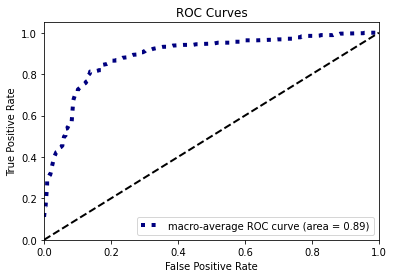

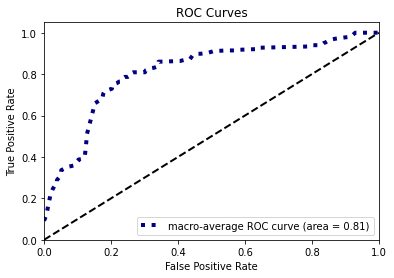

In [92]:
plot_roc_curve(y_true=yt,y_probas=modelo3.predict_proba(Xt),curves='macro')
plot_roc_curve(y_true=yv,y_probas=modelo3.predict_proba(Xv),curves='macro')

## Regresion logistica

In [56]:
modeloRL = LogisticRegression()

In [57]:
hyper = {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear'] }

In [58]:
grid = GridSearchCV(estimator=modeloRL,
                    error_score='raise',
                    param_grid=hyper,
                    cv=3,
                    n_jobs=-1,
                    verbose=True)

In [59]:
grid.fit(Xt,yt)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   13.8s finished


GridSearchCV(cv=3, error_score='raise', estimator=LogisticRegression(),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=True)

In [60]:
print(grid.best_score_)
print(grid.best_params_)

0.7953321723813528
{'C': 0.0018329807108324356, 'penalty': 'l2', 'solver': 'liblinear'}


In [61]:
modeloRL = grid.best_estimator_

modeloRL.fit(Xt,yt)

LogisticRegression(C=0.0018329807108324356, solver='liblinear')

In [62]:
print(roc_auc_score(y_score=modeloRL.predict_proba(Xt)[:,1],y_true=yt))
print(roc_auc_score(y_score=modeloRL.predict_proba(Xv)[:,1],y_true=yv))

0.8138282575561497
0.829548860911271


## Red neuronal

In [39]:
modeloRN = MLPClassifier()

In [40]:
param = dict(hidden_layer_sizes = [(a,b,) for a in range(1,10)  for b in range(1,10)],
activation = ['identity', 'logistic', 'tanh', 'relu'],
solver = ['lbfgs', 'sgd', 'adam'],
alpha = np.arange(0.0001,0.001,0.0001),
learning_rate = ['constant', 'invscaling', 'adaptive'],
learning_rate_init = np.arange(0.001,0.01,0.001),
max_iter = [len(X)*2])

In [41]:
grid = RandomizedSearchCV(estimator=modeloRN,
                          cv=10,
                          n_iter=300,
                          n_jobs=-1,
                          verbose=True,
                          scoring='roc_auc',
                          param_distributions=param)

In [42]:
grid.fit(Xt,yt)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1269 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1835 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2516 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:  3.9min remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.9min finished
/opt/conda/anaconda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_iter=200, momentum=0.9,
                                           n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           ran...
                                                               (3, 5), (3, 6),
                                                               (3, 7), (3, 8),
                      

In [43]:
grid.best_params_

{'solver': 'adam',
 'max_iter': 1564,
 'learning_rate_init': 0.006,
 'learning_rate': 'constant',
 'hidden_layer_sizes': (5, 9),
 'alpha': 0.0009000000000000001,
 'activation': 'tanh'}

In [44]:
grid.best_score_

0.8597716134816898

In [45]:
modeloRN = grid.best_estimator_

In [46]:
modeloRN.fit(Xt,yt)

MLPClassifier(activation='tanh', alpha=0.0009000000000000001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 9), learning_rate='constant',
              learning_rate_init=0.006, max_iter=1564, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

/opt/conda/anaconda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/anaconda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


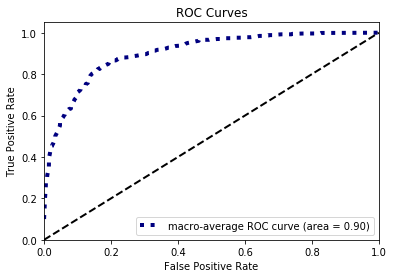

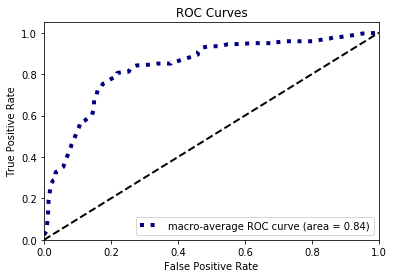

In [48]:
plot_roc_curve(y_true=yt,y_probas=modeloRN.predict_proba(Xt),curves='macro')
plot_roc_curve(y_true=yv,y_probas=modeloRN.predict_proba(Xv),curves='macro')

# Prueba con datos desconocidos

In [49]:
l_arch

['/home/osvaldosantos823/Cuadernos_ML/Kaggle/titanic/datos/test.csv',
 '/home/osvaldosantos823/Cuadernos_ML/Kaggle/titanic/datos/train.csv']

In [50]:
test=pd.read_csv(l_arch[0])
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [51]:
Xtest=reduce(lambda x,y:pd.merge(x,y,on=um,how='outer'), map(lambda v:trans(test,v,varori),vard) )

In [52]:
pre=modeloRN.predict(Xtest[varc])
pre=pd.DataFrame(pre)
pre.columns=[um+tgt]

In [53]:
# Formato
lista=test.loc[:,'PassengerId'].to_list()
lista=pd.DataFrame(lista)
pre=pd.merge(pre,lista,on=pre.index)
pre=pre.drop("key_0",axis=1)
pre.columns=[tgt,um]

In [54]:
pre.head(1)

,Survived,PassengerId
0,0,892


In [56]:
pre.to_csv("/home/osvaldosantos823/salidas/prueba1.csv",index=False)